<a href="https://colab.research.google.com/github/omkar-salunke/Trading_algos/blob/main/CAGR_Back_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas_datareader as pdr
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

#define date range
START = datetime.datetime(2015, 1, 1)
END = datetime.datetime(2020, 12, 31)

YEARS = (END - START).days / 365.25

In [ ]:

#define variables
STARTING_BALANCE = 10000
down_days = 1

In [ ]:

#download data
price = pdr.get_data_yahoo('RELIANCE.NS', START, END)
price.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-28,2018.000000,1995.300049,2006.699951,2003.300049,7947719.0,2003.300049
2020-12-29,2012.300049,1982.550049,2009.000000,1990.050049,8589407.0,1990.050049
2020-12-30,2007.199951,1975.550049,1995.250000,1995.500000,10173132.0,1995.500000
2020-12-31,2011.900024,1978.599976,1993.500000,1985.300049,8667516.0,1985.300049
2021-01-01,1997.000000,1982.000000,1988.000000,1987.500000,4622002.0,1987.500000


In [ ]:
#drop redundant columns
price = price.drop(['High', 'Low', 'Volume', 'Adj Close'], 1)
price.tail()

,Open,Close
Date,,
2020-12-28,2006.699951,2003.300049
2020-12-29,2009.000000,1990.050049
2020-12-30,1995.250000,1995.500000
2020-12-31,1993.500000,1985.300049
2021-01-01,1988.000000,1987.500000


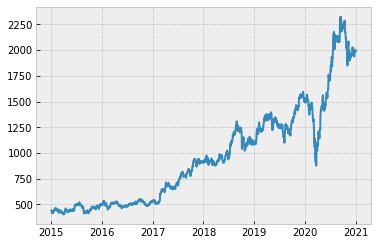

In [ ]:
#plot chart
plt.style.use('bmh')
plt.plot(price.Close)
plt.show()

In [ ]:
#calculate return and balance
price['oc'] = price.Close / price.Open
price['cc'] = price.Close / price.Close.shift(1)
price.cc.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.cc.cumprod()

In [ ]:
#calculate benchmark drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)

bench_dd

-45.09

In [ ]:
#calculate additional columns for strategy

#check if today is a down day
price['Down'] = price.oc < 1

#count consecutive down days
#https://stackoverflow.com/questions/27626542/counting-consecutive-positive-value-in-python-array
down = price['Down']
price['Consecutive'] = down * (down.groupby((down != down.shift()).cumsum()).cumcount() + 1)

price.tail()

,Open,Close,oc,cc,Bench_Bal,Bench_Peak,Bench_DD,Down,Consecutive
Date,,,,,,,,,
2020-12-28,2006.699951,2003.300049,0.998306,1.004588,45552.186929,52856.953911,-7304.766982,True,1
2020-12-29,2009.000000,1990.050049,0.990567,0.993386,45250.900820,52856.953911,-7606.053091,True,2
2020-12-30,1995.250000,1995.500000,1.000125,1.002739,45374.824940,52856.953911,-7482.128971,False,0
2020-12-31,1993.500000,1985.300049,0.995887,0.994889,45142.892593,52856.953911,-7714.061318,True,1
2021-01-01,1988.000000,1987.500000,0.999748,1.001108,45192.916346,52856.953911,-7664.037565,True,2


In [ ]:

#identify entries and allocate trading fees
price['Long'] = price.Consecutive >= down_days

In [ ]:
#calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.cc, 1)
price['Sys_Bal'] = STARTING_BALANCE * price.Sys_Ret.cumprod()

price.tail()

,Open,Close,oc,cc,Bench_Bal,Bench_Peak,Bench_DD,Down,Consecutive,Long,Sys_Ret,Sys_Bal
Date,,,,,,,,,,,,
2020-12-28,2006.699951,2003.300049,0.998306,1.004588,45552.186929,52856.953911,-7304.766982,True,1,True,1.000000,19580.941641
2020-12-29,2009.000000,1990.050049,0.990567,0.993386,45250.900820,52856.953911,-7606.053091,True,2,True,0.993386,19451.431597
2020-12-30,1995.250000,1995.500000,1.000125,1.002739,45374.824940,52856.953911,-7482.128971,False,0,False,1.002739,19504.701289
2020-12-31,1993.500000,1985.300049,0.995887,0.994889,45142.892593,52856.953911,-7714.061318,True,1,True,1.000000,19504.701289
2021-01-01,1988.000000,1987.500000,0.999748,1.001108,45192.916346,52856.953911,-7664.037565,True,2,True,1.001108,19526.314843


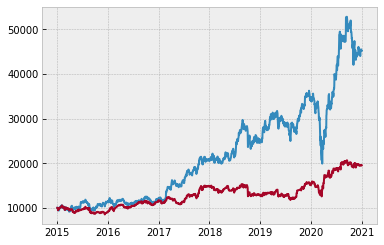

In [ ]:
#plot results
plt.plot(price.Bench_Bal)
plt.plot(price.Sys_Bal)

plt.show()

In [ ]:

#calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

sys_dd

-23.17

In [ ]:
#calculate metrics
bench_return = round(((price.Bench_Bal[-1]/price.Bench_Bal[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
sys_return = round(((price.Sys_Bal[-1]/price.Sys_Bal[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal[-1]/price.Sys_Bal[0])**(1/YEARS))-1)*100), 2)
sys_in_market = round((price.Long.value_counts().loc[True] / len(price)) * 100)
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'Winrate: {sys_winrate}%')

Benchmark Total return: 351.93%
Benchmark CAGR: 28.59
Benchmark DD: -45.09%

System Total return: 95.26%
System CAGR: 11.8
System DD: -23.17%
Time in Market: 53%
Trades Won: 399
Trades Loss: 389
Winrate: 50.63%


In [ ]:
#define list of ETFs to backtest
symbols = ['ITC.NS', 'TATAPOWER.NS', 'ADANIPORTS.NS', 'UBL.NS', 'MCDOWELL-N.NS']

In [ ]:
def backtest(symbol):
    #download data
    price = pdr.get_data_yahoo(symbol, START, END)
    
    #drop redundant columns
    price = price.drop(['High', 'Low', 'Volume', 'Adj Close'], 1)
    
    #calculate return and balance
    price['oc'] = price.Close / price.Open
    price['cc'] = price.Close / price.Close.shift(1)
    price.cc.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.cc.cumprod()
    
    #calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    #check if today is a down day
    price['Down'] = price.oc < 1

    #count consecutive down days
    #https://stackoverflow.com/questions/27626542/counting-consecutive-positive-value-in-python-array
    down = price['Down']
    price['Consecutive'] = down * (down.groupby((down != down.shift()).cumsum()).cumcount() + 1)
    
    price['Long'] = price.Consecutive >= down_days

    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.cc, 1)
    price['Sys_Bal'] = STARTING_BALANCE * price.Sys_Ret.cumprod()
    
    #calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal.cummax()
    price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak
  
    #calculate metrics
    bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_cagr = round(((((price.Sys_Bal[-1]/price.Sys_Bal[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)
    
    return bench_cagr, sys_cagr

In [ ]:
#backtest multiple symbols
bc = []
sc = []


for symbol in symbols:
    bench_cagr, sys_cagr = backtest(symbol)
    bc.append(bench_cagr)
    sc.append(sys_cagr)

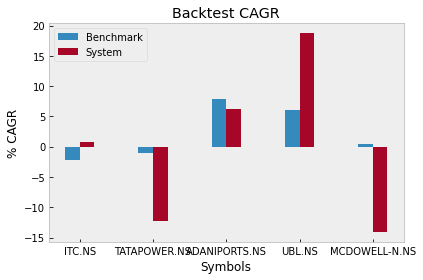

In [ ]:
#plot data
x_indices = np.arange(len(symbols))
width = 0.2

plt.bar(x_indices - width / 2, bc, width = width, label = 'Benchmark')
plt.bar(x_indices + width / 2, sc, width = width, label = 'System')
   
plt.xticks(ticks = x_indices, labels = symbols)

plt.legend()

plt.title('Backtest CAGR')
plt.xlabel('Symbols')
plt.ylabel('% CAGR')
plt.tight_layout()

plt.grid(False)
plt.savefig('saved_figure.png', dpi=500)

plt.show()